In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

%matplotlib notebook

# Fit a visibility function to some results from fringes
This notebook gives an example of how to input some visibility data and fit a function to obtain a source size.

## First enter the data into some arrays

In [2]:
# data           b1    b2   b3   b5   b6

# baseline lengths
b    = np.array([ 4,   1.9,   1, 0.7,   3]) * 1e-3

# visibilities, here squared, though this depends on
# the visibility function you have
v2_r = np.array([0.05,0.24, 0.68,0.77,0.07])**2
v2_g = np.array([0.00,0.127,0.62,0.74,0.099])**2
v2_b = np.array([0.01,0.008,0.46,0.69,0.16])**2

# wavelengths    b    v    r
lam = np.array([430, 520, 600]) * 1e-9

# get b/lambda
u_b = b/lam[0]
u_g = b/lam[1]
u_r = b/lam[2]

# combine
v2_all = np.concatenate((v2_r,v2_g,v2_b))
u_all = np.concatenate((u_r,u_g,u_b))

In [3]:
v2_all

array([2.5000e-03, 5.7600e-02, 4.6240e-01, 5.9290e-01, 4.9000e-03,
       0.0000e+00, 1.6129e-02, 3.8440e-01, 5.4760e-01, 9.8010e-03,
       1.0000e-04, 6.4000e-05, 2.1160e-01, 4.7610e-01, 2.5600e-02])

In [4]:
u_all

array([6666.66666667, 3166.66666667, 1666.66666667, 1166.66666667,
       5000.        , 7692.30769231, 3653.84615385, 1923.07692308,
       1346.15384615, 5769.23076923, 9302.3255814 , 4418.60465116,
       2325.58139535, 1627.90697674, 6976.74418605])

## Or read from numpy save files
Here we took data in a specific sequence, for each baseline we went rgb, and then bgr for the next etc.

In [14]:
lam = np.array([638, 530, 448]) * 1e-9

In [15]:
bs = [0.6,1,2,3,4]
cs = lam

u_all = []
for i,b in enumerate(bs):
    tmp = []
    for c in cs:
        tmp.append((b*1e-3 / c))
    if i % 2 == 1:
        tmp.reverse()

    u_all = u_all + tmp
    
u_all = np.array(u_all)

In [21]:
fs = glob.glob('../../testdata/single/*/*npy')
fs.sort()

v2_all = []
for f in fs:
    v2_all.append(np.load(f)[6])

v2_all = np.array(v2_all)

## Now write a function that we will fit
The first function returns the visibliity squared (though this could equally be just visibility) for some input parameters $p$, which are
- p[0]: the peak of the function at zero baseline, this might not be exactly 1
- p[1]: the angular size in radians of the source

The second function computes the $\chi^2$, though here we have no uncertainties on the visibility measurements so there is no denominator. This function uses the data `v2_all` defined above, so this is a global variable and we do not need to pass it to the function.

In [5]:
# e.g. https://www.eso.org/sci/facilities/paranal/telescopes/vlti/tuto/tutorial_interferometry.html
def vis(p, u):
    return ( 2 * p[0] * scipy.special.jv(1, np.pi*u*p[1]) / (np.pi*u*p[1]) )**2

def chi2_vis(p, u):
    return np.sum( (v2_all - vis(p, u))**2 )

## Do the fitting
The minimisation code takes as input the name of the function we are minimising (`chi2_vis`) and some initial guesses for the two parameters. It also takes the $b/\lambda$ values.

In [6]:
r = scipy.optimize.minimize(chi2_vis, (1,0.0003), args=(u_all), method='Nelder-Mead')

# print the best fit values, the first is the visiblity at zero baseline,
# the second the angular size of the source in radians
print(r['x'])

[8.97599442e-01 2.85205957e-04]


In [7]:
# convert to actual size in mm, assuming distance of 7m
d = 7
r['x'][1] * d * 1e3

1.9964416960870746

## Plot the results

<IPython.core.display.Javascript object>


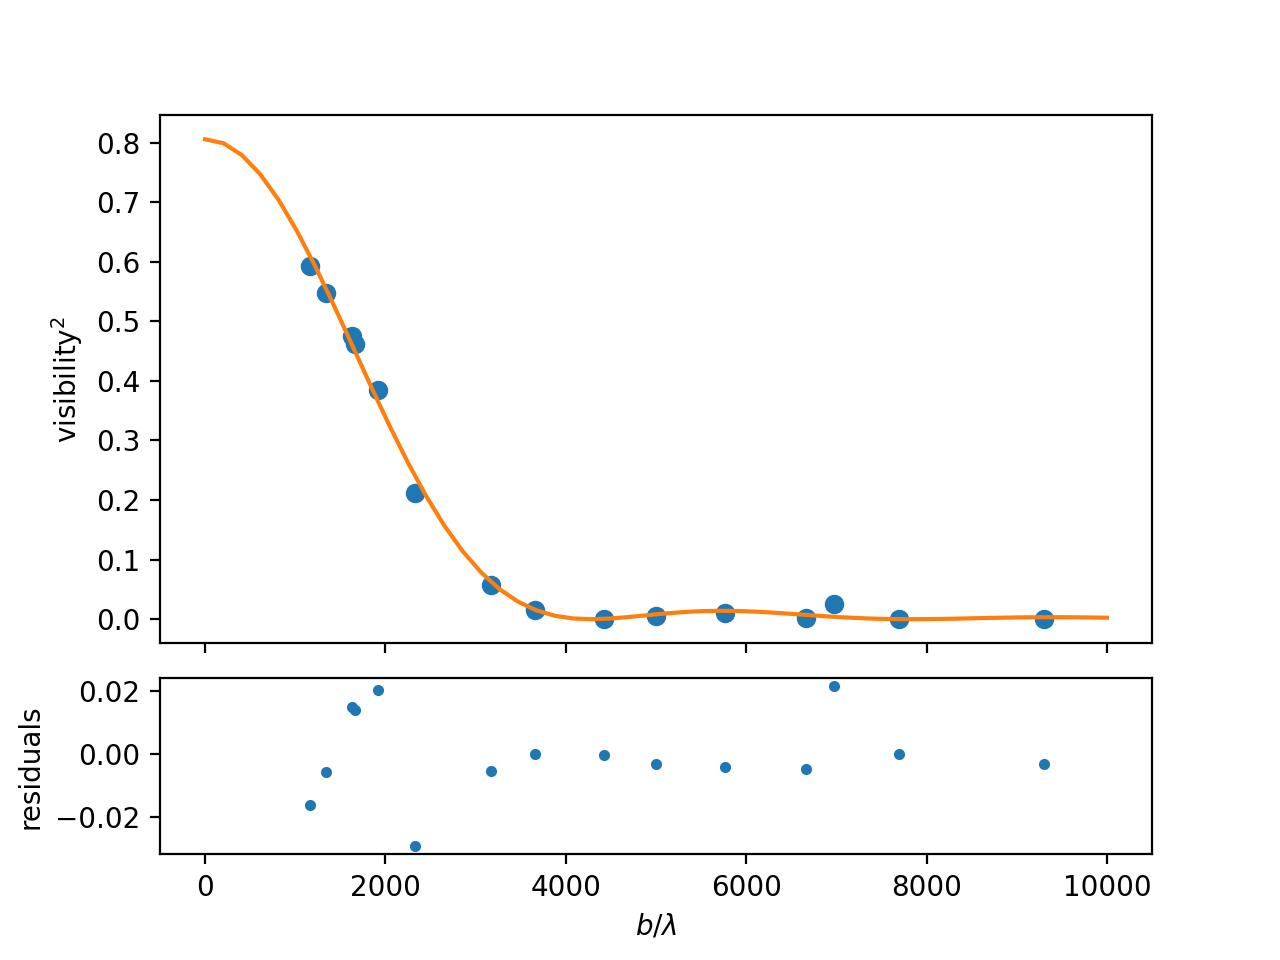

In [8]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# ax[0].plot(u_r, v2_r, '.r')
# ax[0].plot(u_g, v2_g, '.g')
# ax[0].plot(u_b, v2_b, '.b')
ax[0].plot(u_all, v2_all, 'o')

u = np.linspace(1, 1e4)
ax[0].plot(u, vis(r['x'], u))
# ax[0].semilogy(u, vis2(r['x'], u))

ax[1].plot(u_all, (v2_all - vis(r['x'], u_all)), '.')

ax[1].set_xlabel('$b/\lambda$')
ax[0].set_ylabel('visibility$^2$')
ax[1].set_ylabel('residuals')
fig.subplots_adjust(hspace=0.1)